# MOSE playground

## Basic Arguments Settting

In [2]:
import argparse
import random
import numpy as np
import torch
import os
import warnings
from multi_runs import multiple_run

import datetime
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam, SGD
from experiment.dataset import get_data
from models.buffer import Buffer
from train_mose import TrainLearner_MOSE
from models.Resnet18_SD import resnet18_sd
from utils.util import compute_performance

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings('ignore')

args = argparse.Namespace()
setattr(args, 'seed', 0)
setattr(args, 'lr', 1e-3)
setattr(args, 'wd', 1e-4)
setattr(args, 'dataset', 'cifar100')
setattr(args, 'buffer_size', 5000)
setattr(args, 'buffer_batch_size', 64)
setattr(args, 'run_nums', 1)
setattr(args, 'batch_size', 10)
setattr(args, 'ins_t', 0.07)
setattr(args, 'gpu_id', 5)
setattr(args, 'n_workers', 8)

torch.cuda.set_device(args.gpu_id)
args.cuda = torch.cuda.is_available()
print('=' * 100)
print('Arguments =')
for arg in vars(args):
    print('\t' + arg + ':', getattr(args, arg))
np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print('[CUDA is unavailable]')

Arguments =
	seed: 0
	lr: 0.001
	wd: 0.0001
	dataset: cifar100
	buffer_size: 5000
	buffer_batch_size: 64
	run_nums: 1
	batch_size: 10
	ins_t: 0.07
	gpu_id: 5
	n_workers: 8
	cuda: True


## Multiple Run

In [ ]:
test_all_acc = torch.zeros(args.run_nums)
accuracy_list = []

for run in range(args.run_nums):
    tmp_acc = []
    print('=' * 100)
    print(f"-----------------------------run {run} start--------------------------")
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('=' * 100)

    # initialize
    data, class_num, class_per_task, task_loader, input_size = get_data(args.dataset, args.batch_size, args.n_workers)
    args.n_classes = class_num
    buffer = Buffer(args, input_size).cuda()

    model = resnet18_sd(class_num).cuda()
    optimizer = Adam(model.parameters(), lr=args.lr,  weight_decay=1e-4)
    agent = TrainLearner_MOSE(model, buffer, optimizer, class_num, class_per_task, input_size, args)

    # training
    for i in range(len(task_loader)):
        print(f"-----------------------------run {run} task id:{i} start training-----------------------------")

        agent.train(i, task_loader[i]['train'])
        acc_list = agent.test(i, task_loader)
        tmp_acc.append(acc_list)

    test_accuracy = acc_list.mean()
    test_all_acc[run] = test_accuracy
    accuracy_list.append(np.array(tmp_acc))

    print('=' * 100)
    print("{}th run's Test result: Accuracy: {:.2f}%".format(run, test_accuracy))
    print('=' * 100)

    agent.save_checkpoint('./outputs/final.pt')

accuracy_array = np.array(accuracy_list)
avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(accuracy_array)
print('=' * 100)
print(f"total {args.run_nums}runs test acc results: {test_all_acc}")
print('----------- Avg_End_Acc {} Avg_End_Fgt {} Avg_Acc {} Avg_Bwtp {} Avg_Fwt {}-----------'
        .format(avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt))
print('=' * 100)

## Test Ensemble Outputs

In [3]:
# initialize
data, class_num, class_per_task, task_loader, input_size = get_data(args.dataset, args.batch_size, args.n_workers)
args.n_classes = class_num
buffer = Buffer(args, input_size).cuda()
model = resnet18_sd(class_num).cuda()
optimizer = Adam(model.parameters(), lr=args.lr,  weight_decay=1e-4)
agent = TrainLearner_MOSE(model, buffer, optimizer, class_num, class_per_task, input_size, args)

Task order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data and loader is prepared
buffer has 5000 slots
bx torch.Size([5000, 3, 32, 32])


In [4]:
# loading
agent.load_checkpoint('./outputs/final.pt')
agent.buffer.current_index = args.buffer_size - 1

Load checkpoint from: ./outputs/final.pt


In [5]:
def test(agent, i, task_loader, feat_ids=[3]):
    agent.model.eval()
    acc_lists = []
    for feat_id in feat_ids:
        print(f"{'*'*100}\nTest with the output of layer: {feat_id+1}\n")
        agent.class_means = {}
        agent.seen_classes = list(set(agent.buffer.y_int.tolist()))
        class_inputs = {cls: [] for cls in agent.seen_classes}
        for x, y in zip(agent.buffer.x, agent.buffer.y_int):
            class_inputs[y.item()].append(x)

        for cls, inputs in class_inputs.items():
            features = []
            for ex in inputs:
                # feature = agent.model.final_feature(ex.unsqueeze(0)).detach().clone()
                feature = agent.model.features(ex.unsqueeze(0))[feat_id].detach().clone()
                feature = F.normalize(feature, dim=1)
                features.append(feature.squeeze())

            if len(features) == 0:
                mu_y = torch.normal(
                    # 0, 1, size=tuple(agent.model.final_feature(x.unsqueeze(0)).detach().size())
                    0, 1, size=tuple(agent.model.features(x.unsqueeze(0))[feat_id].detach().size())
                )
                mu_y = mu_y.to(x.device)
            else:
                features = torch.stack(features)
                mu_y = features.mean(0)
            mu_y = F.normalize(mu_y.reshape(1, -1), dim=1)
            agent.class_means[cls] = mu_y.squeeze()

        with torch.no_grad():
            acc_list = np.zeros(len(task_loader))
            for j in range(i + 1):
                acc = agent.test_model(task_loader[j]['test'], j, feat_id=feat_id)
                acc_list[j] = acc.item()

            print(f"tasks acc:{acc_list}")
            print(f"tasks avg acc:{acc_list[:i+1].mean()}")
        acc_lists.append(acc_list)

    return acc_lists

In [6]:
# get results of all layers
acc_lists = test(agent, 9, task_loader, feat_ids=[0,1,2,3])

****************************************************************************************************
Test with the output of layer: 1

Test task 0: Accuracy: 509/1000 (50.90%)
Test task 1: Accuracy: 446/1000 (44.60%)
Test task 2: Accuracy: 504/1000 (50.40%)
Test task 3: Accuracy: 417/1000 (41.70%)
Test task 4: Accuracy: 481/1000 (48.10%)
Test task 5: Accuracy: 525/1000 (52.50%)
Test task 6: Accuracy: 473/1000 (47.30%)
Test task 7: Accuracy: 484/1000 (48.40%)
Test task 8: Accuracy: 503/1000 (50.30%)
Test task 9: Accuracy: 495/1000 (49.50%)
tasks acc:[50.90000153 44.59999847 50.40000153 41.70000076 48.09999847 52.5
 47.29999924 48.40000153 50.29999924 49.5       ]
tasks avg acc:48.37000007629395
****************************************************************************************************
Test with the output of layer: 2

Test task 0: Accuracy: 487/1000 (48.70%)
Test task 1: Accuracy: 477/1000 (47.70%)
Test task 2: Accuracy: 552/1000 (55.20%)
Test task 3: Accuracy: 434/1000 (43.40%

In [7]:
with open('./outputs/acc_lists.txt', 'w') as f:
    for acc_list in acc_lists:
        for acc in acc_list:
            f.write(f"{acc:.2f}\t")
        f.write('\n')

In [8]:
acc_lists = np.array(acc_lists)
print(acc_lists.shape)
opt_acc_list = acc_lists.max(axis=0)
print(opt_acc_list)
print(opt_acc_list.mean())

(4, 10)
[50.90000153 47.70000076 55.20000076 43.40000153 51.79999924 54.29999924
 49.70000076 52.79999924 57.         62.70000076]
52.55000038146973


In [ ]:
agent.model.eval()
class_means_ls = [{} for _ in range(4)]
seen_classes = list(set(agent.buffer.y_int.tolist()))
class_inputs = {cls: [] for cls in seen_classes}

for x, y in zip(agent.buffer.x, agent.buffer.y_int):
    class_inputs[y.item()].append(x)

for cls, inputs in class_inputs.items():
    features = [[] for _ in range(4)]
    for ex in inputs:
        features_ls = agent.model.features(ex.unsqueeze(0))
        for feat_id in range(4):
            feature = features_ls[feat_id].detach().clone()
            feature = F.normalize(feature, dim=1)
            features[feat_id].append(feature.squeeze())

    for feat_id in range(4):
        if len(features[feat_id]) == 0:
            mu_y = torch.normal(
                0, 1, size=tuple(agent.model.features(x.unsqueeze(0))[feat_id].detach().size())
            )
            mu_y = mu_y.to(x.device)
        else:
            features[feat_id] = torch.stack(features[feat_id])
            mu_y = features[feat_id].mean(0)
        
        mu_y = F.normalize(mu_y.reshape(1, -1), dim=1)
        class_means_ls[feat_id][cls] = mu_y.squeeze()


In [ ]:
torch.save(class_means_ls, './outputs/class_means_ls.pt')

In [10]:
class_means_ls = torch.load('./outputs/class_means_ls.pt')

In [19]:
# test ncm classifier
seen_classes = list(set(agent.buffer.y_int.tolist()))
agent.model.eval()
for feat_id in range(4):
    print(f"\nTest with feature layer {feat_id}")
    class_means = class_means_ls[feat_id]
    with torch.no_grad():
        acc_list = np.zeros(len(task_loader))
        for j in range(10):
            correct = torch.full([], 0).cuda()
            num = torch.full([], 0).cuda()
            for batch_idx, (data, target) in enumerate(task_loader[j]['test']):
                data, target = data.cuda(), target.cuda()
                features = agent.model.features(data)[feat_id]
                features = F.normalize(features, dim=1)
                features = features.unsqueeze(2)
                means = torch.stack([class_means[cls] for cls in seen_classes])
                means = torch.stack([means] * data.size(0))
                means = means.transpose(1, 2)
                features = features.expand_as(means)
                dists = (features - means).pow(2).sum(1).squeeze()
                pred = dists.min(1)[1]
                pred = torch.Tensor(seen_classes)[pred].to(data.device)

                num += data.size()[0]
                correct += pred.eq(target.data.view_as(pred)).sum()

            test_accuracy = (100. * correct / num)
            acc_list[j] = test_accuracy
            print('Test task {}: Accuracy: {}/{} ({:.2f}%)'.format(j, correct, num, test_accuracy))
    print(f"Average End Accuracy: {acc_list.mean():.2f}%")


Test with feature layer 0


Test task 0: Accuracy: 509/1000 (50.90%)
Test task 1: Accuracy: 446/1000 (44.60%)
Test task 2: Accuracy: 504/1000 (50.40%)
Test task 3: Accuracy: 417/1000 (41.70%)
Test task 4: Accuracy: 481/1000 (48.10%)
Test task 5: Accuracy: 525/1000 (52.50%)
Test task 6: Accuracy: 473/1000 (47.30%)
Test task 7: Accuracy: 484/1000 (48.40%)
Test task 8: Accuracy: 503/1000 (50.30%)
Test task 9: Accuracy: 495/1000 (49.50%)
Average End Accuracy: 48.37%

Test with feature layer 1
Test task 0: Accuracy: 487/1000 (48.70%)
Test task 1: Accuracy: 477/1000 (47.70%)
Test task 2: Accuracy: 552/1000 (55.20%)
Test task 3: Accuracy: 434/1000 (43.40%)
Test task 4: Accuracy: 518/1000 (51.80%)
Test task 5: Accuracy: 532/1000 (53.20%)
Test task 6: Accuracy: 486/1000 (48.60%)
Test task 7: Accuracy: 485/1000 (48.50%)
Test task 8: Accuracy: 521/1000 (52.10%)
Test task 9: Accuracy: 531/1000 (53.10%)
Average End Accuracy: 50.23%

Test with feature layer 2
Test task 0: Accuracy: 495/1000 (49.50%)
Test task 1: Accuracy: 454/

In [25]:
# test ncm classifier
seen_classes = list(set(agent.buffer.y_int.tolist()))
agent.model.eval()
with torch.no_grad():
    acc_list = np.zeros(len(task_loader))
    for j in range(10):
        correct = torch.full([], 0).cuda()
        num = torch.full([], 0).cuda()
        for batch_idx, (data, target) in enumerate(task_loader[j]['test']):
            data, target = data.cuda(), target.cuda()
            features_ls = agent.model.features(data)
            dists_ls = []
            for feat_id in range(4):
                class_means = class_means_ls[feat_id]
                features = features_ls[feat_id]
                features = F.normalize(features, dim=1)
                features = features.unsqueeze(2)
                means = torch.stack([class_means[cls] for cls in seen_classes])
                means = torch.stack([means] * data.size(0))
                means = means.transpose(1, 2)
                features = features.expand_as(means)
                dists = (features - means).pow(2).sum(1).squeeze()
                dists_ls.append(dists)

            dists_ls = torch.cat([dists.unsqueeze(1) for dists in dists_ls], dim=1)
            dists = dists_ls.mean(dim=1).squeeze(1)
            pred = dists.min(1)[1]
            pred = torch.Tensor(seen_classes)[pred].to(data.device)
            num += data.size()[0]
            correct += pred.eq(target.data.view_as(pred)).sum()

        test_accuracy = (100. * correct / num)
        acc_list[j] = test_accuracy
        print('Test task {}: Accuracy: {}/{} ({:.2f}%)'.format(j, correct, num, test_accuracy))
print(f"Average End Accuracy: {acc_list.mean():.2f}%")

Test task 0: Accuracy: 510/1000 (51.00%)
Test task 1: Accuracy: 475/1000 (47.50%)
Test task 2: Accuracy: 556/1000 (55.60%)
Test task 3: Accuracy: 441/1000 (44.10%)
Test task 4: Accuracy: 517/1000 (51.70%)
Test task 5: Accuracy: 561/1000 (56.10%)
Test task 6: Accuracy: 520/1000 (52.00%)
Test task 7: Accuracy: 538/1000 (53.80%)
Test task 8: Accuracy: 601/1000 (60.10%)
Test task 9: Accuracy: 623/1000 (62.30%)
Average End Accuracy: 53.42%


In [ ]:
# test classifier output
agent.model.eval()
# for feat_id in range(4):
with torch.no_grad():
    acc_list = np.zeros(len(task_loader))
    for j in range(9 + 1):
        correct = torch.full([], 0).cuda()
        num = torch.full([], 0).cuda()
        for batch_idx, (data, target) in enumerate(task_loader[j]['test']):
            data, target = data.cuda(), target.cuda()
            # pred = agent.model(data)[feat_id]
            pred = agent.model(data)
            pred = torch.stack(pred, dim=1)
            pred = pred.mean(dim=1).squeeze()
            Pred = pred.data.max(1, keepdim=True)[1]
            num += data.size()[0]
            correct += Pred.eq(target.data.view_as(Pred)).sum()

        test_accuracy = (100. * correct / num)
        print('Test task {}: Accuracy: {}/{} ({:.2f}%)'.format(j, correct, num, test_accuracy))

        acc_list[j] = test_accuracy.item()

    print(f"tasks acc:{acc_list}")
    print(f"tasks avg acc:{acc_list[:9+1].mean()}")

## GSA ce loss modification

In [1]:
import torch
import torch.nn.functional as F

In [3]:
x = torch.randn(128, 100)
y = torch.randn(128, 100)

loss_func = torch.nn.SmoothL1Loss(reduction='mean', beta=1)
print(loss_func(x, y))

tensor(0.7230)


In [4]:
print(torch.dist(x, y, p=2))

tensor(160.2610)


In [5]:
mse = torch.nn.MSELoss(reduction='mean')
print(mse(x,y))

tensor(2.0065)


## Test `wandb.Table`

In [1]:
import wandb
import numpy as np
import pandas as pd

wandb.init(project='mose', entity='994164148', name='test wandb')

# accs_list = np.ones((10, 10))
# num_tasks, _ = accs_list.shape
# col_name = [f"task{i}" for i in range(num_tasks)]
# # accs_table = pd.DataFrame(accs_list, columns=col_name, index=np.array(col_name))
# accs_table = pd.DataFrame(accs_list)
# wandb.log({'test tab;e': wandb.Table(dataframe=accs_table, columns=col_name, rows=col_name)}, commit=False)
# print(accs_table)
# wandb.Table(columns=["a", "b", "c"], data=[["1a", "1b", "1c"], ["2a", "2b", "2c"]])
wandb.log({'test log': 20.0}, 1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 994164148. Use `wandb login --relogin` to force relogin


## Visualization

In [1]:
import os
import pandas as pd

base_dir = './outputs'
folders = []
csv_file_paths = []

for root, _, files in os.walk(base_dir, followlinks=True):
    for file in files:
        if file == 'task_accs_table.csv' and 'epoch' in root:
            folders.append(root)
            csv_file_path = os.path.join(root, file)
            csv_file_paths.append(csv_file_path)

print(len(csv_file_paths))

17


In [2]:
for i in csv_file_paths:
    print(i)

./outputs/er none | cifar100 | 1k | epoch3 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch2 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/mose | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch5 run_00_684/task_accs_table.csv
./outputs/er none | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/er none | cifar100 | 1k | epoch4 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch4 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch2 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch4 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch3 run_00_684/task_accs_table.csv
./outputs/er none | cifar100 | 1k | epoch5 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch3 run

In [7]:
for i in folders:
    print(i)

./outputs/er none | cifar100 | 1k | epoch3 run_00_684
./outputs/scr ocm | cifar100 | 1k | epoch2 run_00_684
./outputs/scr ocm | cifar100 | 1k | epoch1 run_00_684
./outputs/mose | cifar100 | 1k | epoch1 run_00_684
./outputs/er ocm | cifar100 | 1k | epoch1 run_00_684
./outputs/er ocm | cifar100 | 1k | epoch5 run_00_684
./outputs/er none | cifar100 | 1k | epoch1 run_00_684
./outputs/er none | cifar100 | 1k | epoch4 run_00_684
./outputs/scr ocm | cifar100 | 1k | epoch4 run_00_684
./outputs/er ocm | cifar100 | 1k | epoch2 run_00_684
./outputs/er ocm | cifar100 | 1k | epoch4 run_00_684
./outputs/er ocm | cifar100 | 1k | epoch3 run_00_684
./outputs/er none | cifar100 | 1k | epoch5 run_00_684
./outputs/scr ocm | cifar100 | 1k | epoch3 run_00_684
./outputs/mose | cifar100 | 1k | epoch2 run_00_684
./outputs/er none | cifar100 | 1k | epoch2 run_00_684
./outputs/scr ocm | cifar100 | 1k | epoch5 run_00_684


In [16]:
# method, augmentation, epoch
er_data = {}
all_augmentation = ['ocm', 'none']
all_epoch = [f'epoch{i+1}' for i in range(5)]

method = 'er'

for aug in all_augmentation:
    er_data[aug] = {}
    for epoch in all_epoch:
        er_data[aug][epoch] = None 
        for folder, csv_file_path in zip(folders, csv_file_paths):
            if method in folder and aug in folder and epoch in folder:
                print(folder, csv_file_path)
                df = pd.read_csv(csv_file_path)
                er_data[aug][epoch] = df

./outputs/er ocm | cifar100 | 1k | epoch1 run_00_684 ./outputs/er ocm | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch2 run_00_684 ./outputs/er ocm | cifar100 | 1k | epoch2 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch3 run_00_684 ./outputs/er ocm | cifar100 | 1k | epoch3 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch4 run_00_684 ./outputs/er ocm | cifar100 | 1k | epoch4 run_00_684/task_accs_table.csv
./outputs/er ocm | cifar100 | 1k | epoch5 run_00_684 ./outputs/er ocm | cifar100 | 1k | epoch5 run_00_684/task_accs_table.csv
./outputs/er none | cifar100 | 1k | epoch1 run_00_684 ./outputs/er none | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/er none | cifar100 | 1k | epoch2 run_00_684 ./outputs/er none | cifar100 | 1k | epoch2 run_00_684/task_accs_table.csv
./outputs/er none | cifar100 | 1k | epoch3 run_00_684 ./outputs/er none | cifar100 | 1k | epoch3 run_00_684/task_a

In [17]:
print(er_data['ocm']['epoch1'])

  Unnamed: 0      task0      task1      task2  task3      task4      task5  \
0      task0  50.700001   0.000000   0.000000    0.0   0.000000   0.000000   
1      task1  17.000000  39.500000   0.000000    0.0   0.000000   0.000000   
2      task2  12.000000  12.700000  54.799999    0.0   0.000000   0.000000   
3      task3  16.100000  14.700000  29.500000   52.5   0.000000   0.000000   
4      task4  16.799999  16.900000  32.700001   23.1  48.299999   0.000000   
5      task5  22.600000  18.200001  28.600000   20.5  23.600000  52.000000   
6      task6   9.400000  13.600000  23.900000   10.9  20.100000  24.000000   
7      task7  13.100000  16.100000  17.299999   14.7  17.200001  26.799999   
8      task8  13.000000  14.600000  25.400000   21.0  20.299999  24.400000   
9      task9  12.500000   9.400000  24.799999   10.6  18.100000  20.900000   

       task6      task7      task8      task9  
0   0.000000   0.000000   0.000000   0.000000  
1   0.000000   0.000000   0.000000   0.000000

In [15]:
# method, augmentation, epoch
scr_data = {}
all_augmentation = ['ocm']
all_epoch = [f'epoch{i+1}' for i in range(5)]

method = 'scr'

for aug in all_augmentation:
    scr_data[aug] = {}
    for epoch in all_epoch:
        scr_data[aug][epoch] = None 
        for folder, csv_file_path in zip(folders, csv_file_paths):
            if method in folder and aug in folder and epoch in folder:
                print(folder, csv_file_path)
                df = pd.read_csv(csv_file_path)
                scr_data[aug][epoch] = df

./outputs/scr ocm | cifar100 | 1k | epoch1 run_00_684 ./outputs/scr ocm | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch2 run_00_684 ./outputs/scr ocm | cifar100 | 1k | epoch2 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch3 run_00_684 ./outputs/scr ocm | cifar100 | 1k | epoch3 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch4 run_00_684 ./outputs/scr ocm | cifar100 | 1k | epoch4 run_00_684/task_accs_table.csv
./outputs/scr ocm | cifar100 | 1k | epoch5 run_00_684 ./outputs/scr ocm | cifar100 | 1k | epoch5 run_00_684/task_accs_table.csv


In [18]:
print(scr_data['ocm']['epoch1'])

  Unnamed: 0      task0      task1      task2      task3      task4  \
0      task0  50.799999   0.000000   0.000000   0.000000   0.000000   
1      task1  45.700001  42.900002   0.000000   0.000000   0.000000   
2      task2  41.599998  42.299999  52.799999   0.000000   0.000000   
3      task3  35.599998  30.799999  43.500000  49.200001   0.000000   
4      task4  31.400000  35.000000  39.799999  35.099998  52.799999   
5      task5  26.700001  23.200001  34.900002  28.000000  32.900002   
6      task6  21.299999  25.100000  26.500000  24.700001  26.000000   
7      task7  19.500000  23.299999  29.299999  22.900000  22.200001   
8      task8  18.000000  14.800000  24.400000  15.000000  18.100000   
9      task9  17.900000  12.900000  25.000000  15.700000  13.700000   

       task5  task6      task7      task8      task9  
0   0.000000    0.0   0.000000   0.000000   0.000000  
1   0.000000    0.0   0.000000   0.000000   0.000000  
2   0.000000    0.0   0.000000   0.000000   0.000000 

In [19]:
# method, augmentation, epoch
mose_data = {}
all_epoch = [f'epoch{i+1}' for i in range(2)]

method = 'mose'
aug = 'ocm'

mose_data[aug] = {}
for epoch in all_epoch:
    mose_data[aug][epoch] = None 
    for folder, csv_file_path in zip(folders, csv_file_paths):
        if method in folder and epoch in folder:
            print(folder, csv_file_path)
            df = pd.read_csv(csv_file_path)
            mose_data[aug][epoch] = df

./outputs/mose | cifar100 | 1k | epoch1 run_00_684 ./outputs/mose | cifar100 | 1k | epoch1 run_00_684/task_accs_table.csv
./outputs/mose | cifar100 | 1k | epoch2 run_00_684 ./outputs/mose | cifar100 | 1k | epoch2 run_00_684/task_accs_table.csv


In [20]:
print(mose_data['ocm']['epoch1'])

  Unnamed: 0      task0      task1      task2      task3      task4  \
0      task0  74.699997   0.000000   0.000000   0.000000   0.000000   
1      task1  59.700001  70.300003   0.000000   0.000000   0.000000   
2      task2  50.599998  57.700001  72.800003   0.000000   0.000000   
3      task3  48.099998  46.200001  57.900002  67.699997   0.000000   
4      task4  43.200001  46.599998  51.599998  50.900002  70.699997   
5      task5  37.700001  40.700001  48.599998  44.099998  49.000000   
6      task6  33.500000  36.099998  42.200001  40.000000  42.000000   
7      task7  31.600000  34.400002  37.099998  34.599998  36.200001   
8      task8  28.600000  28.200001  37.099998  29.900000  31.799999   
9      task9  25.299999  24.000000  32.400002  22.100000  24.600000   

       task5      task6      task7      task8      task9  
0   0.000000   0.000000   0.000000   0.000000   0.000000  
1   0.000000   0.000000   0.000000   0.000000   0.000000  
2   0.000000   0.000000   0.000000   0.00

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

er: [29.399999618530277, 28.399999618530277, 24.799999237060547, 23.399999618530277, 16.5] [17.0, 28.399999618530277, 42.5, 47.70000076293945, 50.5]
scr: [45.70000076293945, 52.20000076293945, 53.20000076293945, 57.79999923706055, 47.79999923706055]
mose: [59.70000076293945, 62.400001525878906]


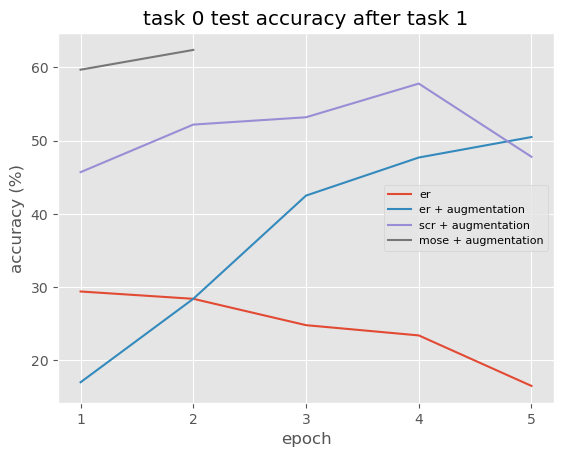

In [97]:
# error rate task0 @ task1 across 5 epochs

test_task_name = 'task0'
current_task_id = 1

# er
er_none, er_ocm = [], []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    none_df = er_data['none'][epoch]
    er_none.append(none_df.iloc[current_task_id][test_task_name])

    ocm_df = er_data['ocm'][epoch]
    er_ocm.append(ocm_df.iloc[current_task_id][test_task_name])
print('er:', er_none, er_ocm)

# scr
scr_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    scr_ocm_df = scr_data['ocm'][epoch]
    scr_ocm.append(scr_ocm_df.iloc[current_task_id][test_task_name])

print('scr:', scr_ocm)

# mose
mose_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(2)]
for epoch in all_epoch:
    mose_ocm_df = mose_data['ocm'][epoch]
    mose_ocm.append(mose_ocm_df.iloc[current_task_id][test_task_name])

print('mose:', mose_ocm)

x = np.arange(1, 6)

figure = plt.figure()
plt.plot(x, er_none, label='er')
plt.plot(x, er_ocm,  label='er + augmentation')
plt.plot(x, scr_ocm, label='scr + augmentation')
plt.plot(x[:2], mose_ocm, label='mose + augmentation')

plt.xlabel('epoch')
plt.xticks(x)
plt.ylabel('accuracy (%)')
plt.title('task 0 test accuracy after task 1')
plt.legend(loc='best', fontsize=8)
plt.show()

er: [57.5, 67.19999694824219, 66.0999984741211, 67.5, 67.9000015258789] [50.70000076293945, 57.900001525878906, 62.70000076293945, 70.0999984741211, 76.9000015258789]
scr: [50.79999923706055, 69.69999694824219, 70.0, 75.4000015258789, 77.5999984741211]
mose: [74.69999694824219, 80.4000015258789]


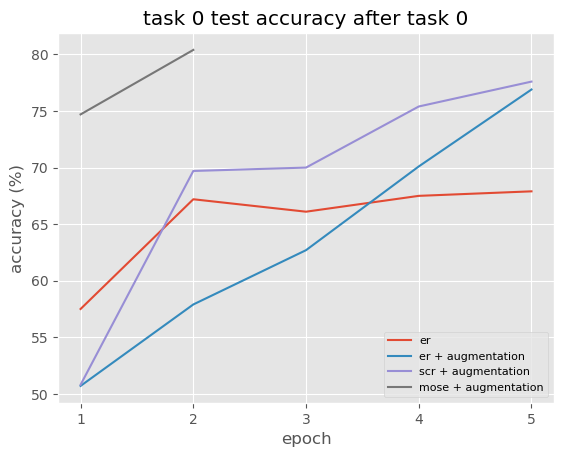

In [98]:
# error rate task0 @ task1 across 5 epochs

test_task_name = 'task0'
current_task_id = 0

# er
er_none, er_ocm = [], []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    none_df = er_data['none'][epoch]
    er_none.append(none_df.iloc[current_task_id][test_task_name])

    ocm_df = er_data['ocm'][epoch]
    er_ocm.append(ocm_df.iloc[current_task_id][test_task_name])
print('er:', er_none, er_ocm)

# scr
scr_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    scr_ocm_df = scr_data['ocm'][epoch]
    scr_ocm.append(scr_ocm_df.iloc[current_task_id][test_task_name])

print('scr:', scr_ocm)

# mose
mose_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(2)]
for epoch in all_epoch:
    mose_ocm_df = mose_data['ocm'][epoch]
    mose_ocm.append(mose_ocm_df.iloc[current_task_id][test_task_name])

print('mose:', mose_ocm)

x = np.arange(1, 6)

figure = plt.figure()
plt.plot(x, er_none, label='er')
plt.plot(x, er_ocm,  label='er + augmentation')
plt.plot(x, scr_ocm, label='scr + augmentation')
plt.plot(x[:2], mose_ocm, label='mose + augmentation')

plt.xlabel('epoch')
plt.xticks(x)
plt.ylabel('accuracy (%)')
plt.title('task 0 test accuracy after task 0')
plt.legend(loc='best', fontsize=8)
plt.show()

er: [54.79999923706055, 61.29999923706055, 64.0, 64.4000015258789, 66.0999984741211] [39.5, 55.70000076293945, 64.4000015258789, 67.9000015258789, 68.19999694824219]
scr: [42.900001525878906, 62.59999847412109, 69.5, 71.0999984741211, 76.30000305175781]
mose: [70.30000305175781, 75.80000305175781]


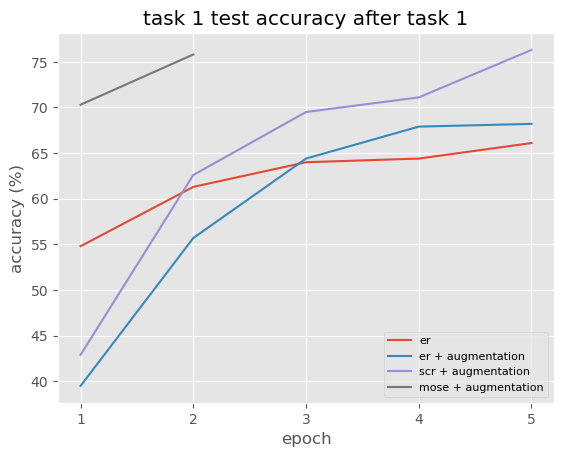

In [99]:
# error rate task0 @ task1 across 5 epochs

test_task_name = 'task1'
current_task_id = 1

# er
er_none, er_ocm = [], []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    none_df = er_data['none'][epoch]
    er_none.append(none_df.iloc[current_task_id][test_task_name])

    ocm_df = er_data['ocm'][epoch]
    er_ocm.append(ocm_df.iloc[current_task_id][test_task_name])
print('er:', er_none, er_ocm)

# scr
scr_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    scr_ocm_df = scr_data['ocm'][epoch]
    scr_ocm.append(scr_ocm_df.iloc[current_task_id][test_task_name])

print('scr:', scr_ocm)

# mose
mose_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(2)]
for epoch in all_epoch:
    mose_ocm_df = mose_data['ocm'][epoch]
    mose_ocm.append(mose_ocm_df.iloc[current_task_id][test_task_name])

print('mose:', mose_ocm)

x = np.arange(1, 6)

figure = plt.figure()
plt.plot(x, er_none, label='er')
plt.plot(x, er_ocm,  label='er + augmentation')
plt.plot(x, scr_ocm, label='scr + augmentation')
plt.plot(x[:2], mose_ocm, label='mose + augmentation')

plt.xlabel('epoch')
plt.xticks(x)
plt.ylabel('accuracy (%)')
plt.title('task 1 test accuracy after task 1')
plt.legend(loc='best', fontsize=8)
plt.show()

er: [42.09999942779541, 44.84999942779541, 44.39999961853027, 43.90000057220459, 41.29999923706055] [28.25, 42.05000019073486, 53.45000076293945, 57.80000114440918, 59.349998474121094]
scr: [44.30000114440918, 57.39999961853027, 61.35000038146973, 64.44999885559082, 62.05000114440918]
mose: [65.00000190734863, 69.10000228881836]


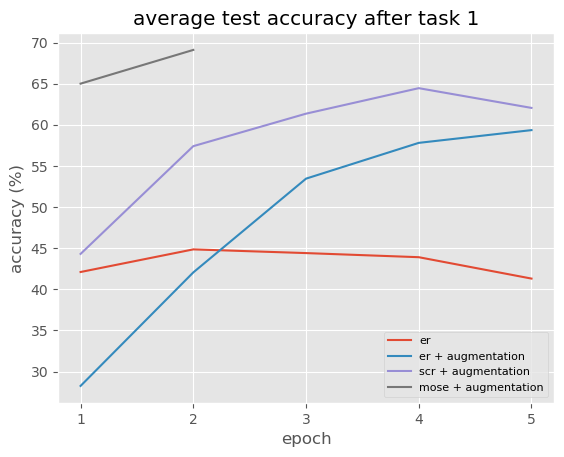

In [101]:
# error rate task0 @ task1 across 5 epochs

test_task_name = 'task0'
test_task_name_2 = 'task1'
current_task_id = 1

# er
er_none, er_ocm = [], []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    none_df = er_data['none'][epoch]
    er_none.append((none_df.iloc[current_task_id][test_task_name]+none_df.iloc[current_task_id][test_task_name_2])/2)

    ocm_df = er_data['ocm'][epoch]
    er_ocm.append((ocm_df.iloc[current_task_id][test_task_name]+ocm_df.iloc[current_task_id][test_task_name_2])/2)
print('er:', er_none, er_ocm)

# scr
scr_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(5)]
for epoch in all_epoch:
    scr_ocm_df = scr_data['ocm'][epoch]
    scr_ocm.append((scr_ocm_df.iloc[current_task_id][test_task_name]+scr_ocm_df.iloc[current_task_id][test_task_name_2])/2)

print('scr:', scr_ocm)

# mose
mose_ocm = []
all_epoch = [f'epoch{i+1}' for i in range(2)]
for epoch in all_epoch:
    mose_ocm_df = mose_data['ocm'][epoch]
    mose_ocm.append((mose_ocm_df.iloc[current_task_id][test_task_name]+mose_ocm_df.iloc[current_task_id][test_task_name_2])/2)

print('mose:', mose_ocm)

x = np.arange(1, 6)

figure = plt.figure()
plt.plot(x, er_none, label='er')
plt.plot(x, er_ocm,  label='er + augmentation')
plt.plot(x, scr_ocm, label='scr + augmentation')
plt.plot(x[:2], mose_ocm, label='mose + augmentation')

plt.xlabel('epoch')
plt.xticks(x)
plt.ylabel('accuracy (%)')
plt.title('average test accuracy after task 1')
plt.legend(loc='best', fontsize=8)
plt.show()